In [1]:
# ==========================================
# CELLA 1: CONFIGURAZIONE E BOOTSTRAP (FIXED)
# ==========================================
import os
import sys
import shutil

# =============================================================================
# 1. ENVIRONMENT SANITIZATION (Reset)
# =============================================================================
print(">>> Executing Environment Reset (Clean Slate)...")
try:
    os.chdir('/content/')
    # Usiamo shutil per una rimozione più sicura in ambiente Python
    if os.path.exists('Hawk-AI-CV-Project'):
        shutil.rmtree('Hawk-AI-CV-Project')
except Exception as e:
    print(f"Note: Reset non necessario o errore minore: {e}")

# =============================================================================
# 2. SOURCE CODE RETRIEVAL (Clone)
# =============================================================================
print(">>> Cloning Repository...")
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# =============================================================================
# 3. RUNTIME CONTEXT & PATH CONFIGURATION
# =============================================================================
repo_name = "Hawk-AI-CV-Project"
%cd {repo_name}

# Iniettiamo la root del progetto nel PATH per gli import assoluti
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

# =============================================================================
# 4. DEPENDENCY RESOLUTION
# =============================================================================
print(">>> Installing Runtime Dependencies...")
# Forziamo l'aggiornamento per evitare conflitti di versione tra numpy e opencv
!pip install --upgrade numpy opencv-python matplotlib pandas

# =============================================================================
# 5. VERIFICATION & ASSET CHECK (Cruciale per il debug)
# =============================================================================
print("\n>>> Setup Complete. Active Runtime Root:")
print(os.getcwd())

try:
    import numpy as np
    import cv2 as cv
    import pandas as pd
    print(f">>> Dependencies verified: OpenCV {cv.__version__} | Numpy {np.__version__}")

    # Check se i file necessari sono presenti
    file_necessari = ['src/config.py', 'src/homography_calculator.py']
    for f in file_necessari:
        if os.path.exists(f):
            print(f"✅ File di sistema trovato: {f}")
        else:
            print(f"❌ ATTENZIONE: File mancante: {f}")

except ImportError as e:
    print(f"!!! CRITICAL ERROR: Dependency installation failed - {e}")

# =============================================================================
# NOTA PER IL PROSSIMO STEP:
# Una volta eseguita questa cella, passami la cella dove definisci
# la logica di 'is_point_in' e 'HawkEyeJudge'.
# =============================================================================

>>> Executing Environment Reset (Clean Slate)...
>>> Cloning Repository...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 891, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 891 (delta 51), reused 0 (delta 0), pack-reused 775 (from 2)
Receiving objects: 100% (891/891), 89.85 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/Hawk-AI-CV-Project
>>> Installing Runtime Dependencies...

>>> Setup Complete. Active Runtime Root:
/content/Hawk-AI-CV-Project
>>> Dependencies verified: OpenCV 4.13.0 | Numpy 2.4.1
✅ File di sistema trovato: src/config.py
✅ File di sistema trovato: src/homography_calculator.py


In [2]:
# =============================================================================
# CELLA 2: HAWK-EYE ENGINE - GRAFICA RESPONSIVA (Adatta a ogni risoluzione)
# =============================================================================
import cv2 as cv
import numpy as np

# CONFIGURAZIONE LIMITI CAMPO
# Y=0: Linea Servizio (T) | Y=6.40: Rete | Y=-5.49: Fondo Nostro | Y=18.29: Fondo Avversario
COURT_DIMENSIONS = {
    'X_MIN': -0.15, 'X_MAX': 8.38,
    'Y_MIN': -5.60, 'Y_MAX': 18.50
}

def is_point_in(x, y):
    if x is None or y is None: return False
    return (COURT_DIMENSIONS['X_MIN'] <= x <= COURT_DIMENSIONS['X_MAX'] and
            COURT_DIMENSIONS['Y_MIN'] <= y <= COURT_DIMENSIONS['Y_MAX'])

class HawkEyeJudge:
    def __init__(self, homography_matrix):
        self.H = np.array(homography_matrix, dtype=np.float32)

    def pixel_to_world(self, u, v):
        src_pt = np.array([[[u, v]]], dtype=np.float32)
        dst_pt = cv.perspectiveTransform(src_pt, self.H)
        return dst_pt[0][0][0], dst_pt[0][0][1]

    def detect_bounces(self, trajectory):
        bounces = []
        if len(trajectory) < 5: return bounces
        last_bounce_frame = -50

        for t in range(2, len(trajectory) - 2):
            prev, curr, nxt = trajectory[t-1], trajectory[t], trajectory[t+1]
            if prev is None or curr is None or nxt is None: continue

            v_vel_in  = curr[1] - prev[1]
            v_vel_out = nxt[1] - curr[1]

            # Soglia Velocità e Filtro Temporale
            if v_vel_in > 1.5 and v_vel_out <= 0:
                if (t - last_bounce_frame) > 15:
                    # Sanity Check
                    wx, wy = self.pixel_to_world(prev[0], prev[1])
                    if -10.0 <= wy <= 20.0 and -5.0 <= wx <= 12.0:
                        bounces.append({'frame': t, 'pixel': prev})
                        last_bounce_frame = t
                        print(f"✅ Rimbalzo RILEVATO Frame {t}: Y={wy:.2f}m")
        return bounces

    def adjudicate_video(self, video_path, trajectory, output_path):
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ Errore apertura video: {video_path}")
            return

        fps = cap.get(cv.CAP_PROP_FPS)
        w, h = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        out = cv.VideoWriter(output_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

        bounces = self.detect_bounces(trajectory)
        print(f"🎾 TOTALE RIMBALZI VALIDI: {len(bounces)}")

        decisions = {}
        for b in bounces:
            f_idx = b['frame']
            px, py = b['pixel']
            wx, wy = self.pixel_to_world(px, py)

            if wx is not None:
                verdict = "IN" if is_point_in(wx, wy) else "OUT"
                color = (0, 255, 0) if verdict == "IN" else (0, 0, 255)
                decisions[f_idx] = {'verdict': verdict, 'coords': (wx, wy), 'color': color}
                print(f"   -> Frame {f_idx} | World: X={wx:.2f}, Y={wy:.2f} | {verdict}")

        frame_count = 0
        display_timer = 0
        current_display = None

        # --- PARAMETRI GRAFICI RESPONSIVI (NUOVA SEZIONE) ---
        # Adattiamo tutto alla larghezza del video (w)

        # 1. Dimensione Font (Scala)
        # Su un video 2880px -> scale ~2.0
        # Su un video 640px  -> scale ~0.45
        font_scale_verdict = max(0.5, w / 1500.0)
        font_scale_coords = max(0.3, font_scale_verdict * 0.4)

        # 2. Spessore linee
        thickness = max(1, int(w / 600.0))

        # 3. Dimensioni Box Nero
        # Larghezza fissa al 25% del video, Altezza al 15%
        box_w = int(w * 0.25)
        box_h = int(h * 0.15)

        # 4. Posizione (Margine in alto a sinistra)
        box_x, box_y = int(w * 0.03), int(h * 0.03)

        while True:
            ret, frame = cap.read()
            if not ret: break

            if frame_count in decisions:
                current_display = decisions[frame_count]
                # Durata scritta (0.8 secondi)
                display_timer = int(fps * 0.8)

            # Disegna traiettoria
            if frame_count < len(trajectory) and trajectory[frame_count] is not None:
                cv.circle(frame, (int(trajectory[frame_count][0]), int(trajectory[frame_count][1])), 4, (0, 255, 255), -1)

            # Disegna Overlay Risultato
            if display_timer > 0 and current_display:
                # Sfondo Nero
                cv.rectangle(frame, (box_x, box_y), (box_x + box_w, box_y + box_h), (0,0,0), -1)

                # Calcolo posizione testo centrato nel box
                # Offset X (10% dentro il box)
                text_x = box_x + int(box_w * 0.1)

                # Offset Y per "IN/OUT" (60% altezza box)
                text_y = box_y + int(box_h * 0.6)

                cv.putText(frame, current_display['verdict'], (text_x, text_y),
                           cv.FONT_HERSHEY_SIMPLEX, font_scale_verdict, current_display['color'], thickness)

                # Offset Y per Coordinate (85% altezza box)
                coord_y = box_y + int(box_h * 0.85)

                cv.putText(frame, f"X:{current_display['coords'][0]:.1f} Y:{current_display['coords'][1]:.1f}",
                           (text_x, coord_y), cv.FONT_HERSHEY_SIMPLEX, font_scale_coords, (255,255,255), 1)

                display_timer -= 1

            out.write(frame)
            frame_count += 1

        cap.release()
        out.release()
        print(f"✅ Video salvato in: {output_path}")

In [3]:
# ==========================================
# CELLA 3: ESECUZIONE GIUDICE (SELEZIONE SINGOLO VIDEO + AUTO-SCALE)
# ==========================================
import pandas as pd
import numpy as np
import glob
import os
import cv2 as cv
from google.colab import files

# =============================================================================
# 1. CONFIGURAZIONE UTENTE
# =============================================================================
NUMERO_VIDEO = 2   # <--- SCRIVI QUI IL NUMERO DEL VIDEO (es. 2 per video2)

# =============================================================================

# 2. MATRICE H (Calibrata su 1075x613) - FISSA
H_MATRIX = np.array([
    [ 6.50980565e-02,  2.65116930e-02, -3.04981716e+01],
    [ 3.86372362e-04, -1.97434738e-01,  7.91002378e+01],
    [ 1.76143090e-04,  6.49680276e-03,  1.00000000e+00]
])

# Risoluzione di Riferimento della matrice H
CALIBRATION_W, CALIBRATION_H = 1075, 613

print("🚀 Inizializzazione Hawk-Eye Judicial Engine...")
judge = HawkEyeJudge(H_MATRIX)

# Costruiamo i nomi dei file in base al numero scelto
nome_csv = f"DATI_video{NUMERO_VIDEO}.csv"
nome_base = f"video{NUMERO_VIDEO}"

# Controlla se il CSV esiste
if not os.path.exists(nome_csv):
    print(f"❌ ERRORE: Il file '{nome_csv}' non è stato trovato!")
    print(f"   Assicurati di aver generato il CSV con YOLO e di averlo caricato.")
else:
    print(f"\n" + "="*50)
    print(f"📂 File Dati trovato: {nome_csv}")

    # Cerca il video corrispondente (.mov, .mp4, .avi)
    video_path = None
    possible_extensions = [".mov", ".mp4", ".avi"]

    # Cerca nella cartella corrente o nella sottocartella del progetto
    possibili_percorsi = [f"{nome_base}{ext}" for ext in possible_extensions] + \
                         [f"/content/Hawk-AI-CV-Project/{nome_base}{ext}" for ext in possible_extensions]

    for p in possibili_percorsi:
        if os.path.exists(p):
            video_path = p
            break

    if video_path:
        # APRIAMO IL VIDEO PER LEGGERE LA RISOLUZIONE REALE (es. 640x360)
        cap_temp = cv.VideoCapture(video_path)
        if not cap_temp.isOpened():
             print(f"❌ Impossibile aprire il file video: {video_path}")
        else:
            real_w = int(cap_temp.get(cv.CAP_PROP_FRAME_WIDTH))
            real_h = int(cap_temp.get(cv.CAP_PROP_FRAME_HEIGHT))
            cap_temp.release()

            print(f"✅ Analisi Video: {video_path}")
            print(f"   📏 Risoluzione rilevata: {real_w}x{real_h}")

            # Calcolo automatico della scala
            # Se il video è 640x360, scalerà le coordinate per arrivare a 1075x613
            scale_u = CALIBRATION_W / real_w
            scale_v = CALIBRATION_H / real_h
            print(f"   ⚖️  Fattore di scala applicato: X: {scale_u:.3f} | Y: {scale_v:.3f}")

            # Carichiamo i dati
            df = pd.read_csv(nome_csv)
            # Creiamo una lista vuota lunga quanto il video
            max_frame = int(df['frame'].max())
            trajectory_list = [None] * (max_frame + 200)

            for _, row in df.iterrows():
                f = int(row['frame'])
                # Applichiamo la scala letta dal video
                u = float(row['u']) * scale_u
                v = float(row['v']) * scale_v

                if not (np.isnan(u) or np.isnan(v)):
                    trajectory_list[f] = (u, v)

            # ESECUZIONE GIUDIZIO
            output_name = f"FINAL_JUDGE_{nome_base}.mp4"
            judge.adjudicate_video(video_path, trajectory_list, output_name)

            if os.path.exists(output_name):
                print(f"💾 Download automatico in corso...")
                files.download(output_name)
    else:
        print(f"❌ Video '{nome_base}' non trovato (cercato .mp4, .mov, .avi).")
        print("   Carica il file video nella barra a sinistra!")

🚀 Inizializzazione Hawk-Eye Judicial Engine...

📂 File Dati trovato: DATI_video2.csv
✅ Analisi Video: video2.mp4
   📏 Risoluzione rilevata: 1280x720
   ⚖️  Fattore di scala applicato: X: 0.840 | Y: 0.851
✅ Rimbalzo RILEVATO Frame 32: Y=8.33m
✅ Rimbalzo RILEVATO Frame 48: Y=13.89m
✅ Rimbalzo RILEVATO Frame 64: Y=7.82m
✅ Rimbalzo RILEVATO Frame 86: Y=2.06m
✅ Rimbalzo RILEVATO Frame 103: Y=-1.49m
✅ Rimbalzo RILEVATO Frame 158: Y=1.49m
✅ Rimbalzo RILEVATO Frame 178: Y=12.77m
✅ Rimbalzo RILEVATO Frame 222: Y=-2.43m
✅ Rimbalzo RILEVATO Frame 238: Y=14.71m
✅ Rimbalzo RILEVATO Frame 268: Y=-4.75m
🎾 TOTALE RIMBALZI VALIDI: 10
   -> Frame 32 | World: X=5.77, Y=8.33 | IN
   -> Frame 48 | World: X=5.63, Y=13.89 | IN
   -> Frame 64 | World: X=2.33, Y=7.82 | IN
   -> Frame 86 | World: X=5.89, Y=2.06 | IN
   -> Frame 103 | World: X=7.76, Y=-1.49 | IN
   -> Frame 158 | World: X=3.97, Y=1.49 | IN
   -> Frame 178 | World: X=2.22, Y=12.77 | IN
   -> Frame 222 | World: X=5.98, Y=-2.43 | IN
   -> Frame 238

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

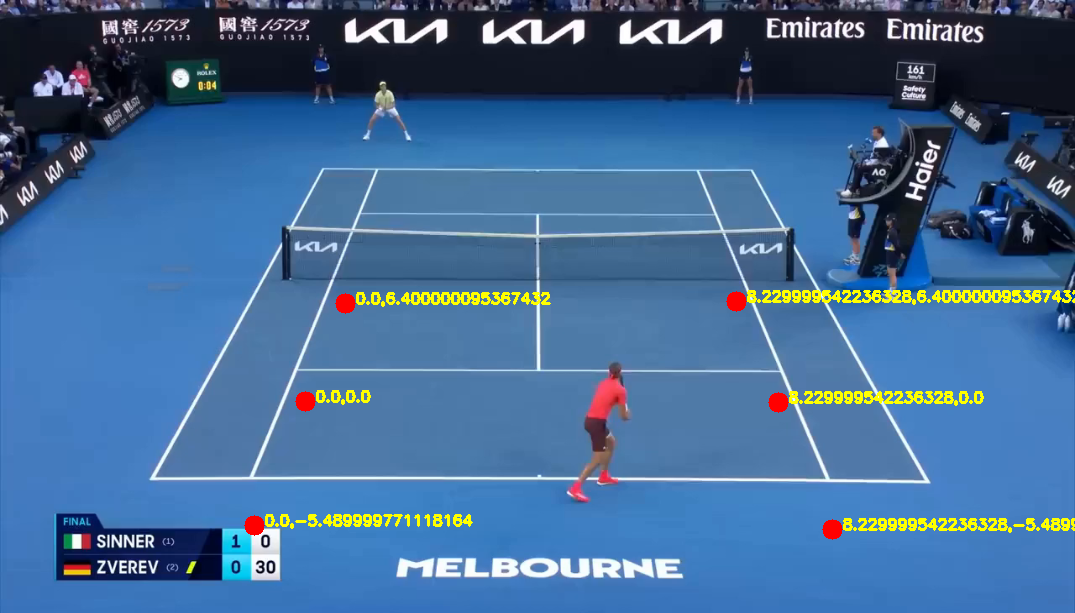

In [4]:
# ==========================================
# CELLA DI DEBUG: VISUALIZZA LA GRIGLIA
# ==========================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

H_MATRIX = np.array([
    [6.50980565e-02, 2.65116930e-02, -3.04981716e+01],
    [3.86372362e-04, -1.97434738e-01, 7.91002378e+01],
    [1.76143090e-04, 6.49680276e-03, 1.00000000e+00]
])

# 2. Definiamo i 4 angoli del campo (in METRI) secondo il sistema M3
# Ordine: [0,0] (Servizio SX), [8.23, 0] (Servizio DX), [8.23, 6.40] (Rete DX), [0, 6.40] (Rete SX)
# Usiamo i punti chiave delle righe del singolare
punti_metri = np.array([
    [0.0,  0.0],   # Intersezione T servizio / laterale sinistra
    [8.23, 0.0],   # Intersezione T servizio / laterale destra
    [8.23, 6.40],  # Rete / laterale destra
    [0.0,  6.40],  # Rete / laterale sinistra
    [0.0, -5.49],  # Fondo / laterale sinistra
    [8.23, -5.49]  # Fondo / laterale destra
], dtype='float32')

def disegna_campo_su_frame(frame, H):
    # Calcoliamo l'inversa per proiettare Metri -> Pixel
    try:
        H_inv = np.linalg.inv(H)
    except:
        print("La matrice non è invertibile!")
        return frame

    # Convertiamo i punti metri in coordinate omogenee [x, y, 1] h, w = frame.shape[:2]
    pts_pixel = []

    for pm in punti_metri:
        vec_m = np.array([pm[0], pm[1], 1])
        vec_px = np.dot(H_inv, vec_m)

        # Normalizza
        if vec_px[2] != 0:
            u = int(vec_px[0] / vec_px[2])
            v = int(vec_px[1] / vec_px[2])
            pts_pixel.append((u, v))

            # Disegna punto
            cv.circle(frame, (u, v), 10, (0, 0, 255), -1)
            cv.putText(frame, f"{pm[0]},{pm[1]}", (u+10, v), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)

    return frame

# --- TEST SU UN FRAME A CASO DEL TUO VIDEO ---
video_path = "video2.mp4" # <--- CONTROLLA NOME FILE
cap = cv.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    # 🔴 FIX FONDAMENTALE: stesso spazio dell’omografia
    frame = cv.resize(frame, (1075, 613))

    frame_debug = disegna_campo_su_frame(frame, H_MATRIX)
    cv2_imshow(frame_debug)
else:
    print("Impossibile leggere il video per il debug.")
cap.release()
